### Necessary Imports and Installs

In [ ]:
!pip install opendatasets

In [ ]:
!rm -rf GLC
!git clone https://github.com/maximiliense/GLC

Cloning into 'GLC'...
remote: Enumerating objects: 383, done.
remote: Counting objects: 100% (228/228), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 383 (delta 119), reused 170 (delta 63), pack-reused 155
Receiving objects: 100% (383/383), 10.57 MiB | 47.05 MiB/s, done.
Resolving deltas: 100% (205/205), done.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Add, GlobalAveragePooling2D, Conv2D, Dense, AveragePooling2D, \
BatchNormalization, Normalization, Dropout, Flatten, Lambda, Input, Activation
from tensorflow.keras import Model
from tensorflow.keras.optimizers import schedules, SGD
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import scale
import time
from collections import defaultdict
import math
import copy
import opendatasets as od

%pylab inline --no-import-all
from pathlib import Path
import pandas as pd
import sys

Populating the interactive namespace from numpy and matplotlib


# Dataset

## Download Dataset

{"username":"nathaliemh","key":"cba80d1f619e96b238e4a95aa3017836"}

In [ ]:
data = od.download("https://www.kaggle.com/competitions/geolifeclef-2022-lifeclef-2022-fgvc9")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kennedysalamat
Your Kaggle Key: ··········


100%|██████████| 57.6G/57.6G [07:09<00:00, 144MB/s]



Extracting archive ./geolifeclef-2022-lifeclef-2022-fgvc9/geolifeclef-2022-lifeclef-2022-fgvc9.zip to ./geolifeclef-2022-lifeclef-2022-fgvc9


## Load Dataset from file

In [ ]:
# Change this path to adapt to where you downloaded the data
DATA_PATH = "./geolifeclef-2022-lifeclef-2022-fgvc9/"

In [ ]:
import time
hours = 4
#time.sleep(60*60*hours)

In [ ]:
ls -L $DATA_PATH

metadata/      patches-fr/      patches-us/     rasters/
observations/  patches_sample/  pre-extracted/  sample_submission.csv


In [ ]:
ls $DATA_PATH/observations

observations_fr_test.csv   observations_us_test.csv
observations_fr_train.csv  observations_us_train.csv


In [ ]:
### Training Dataset ###
# let's load the data from file
df_obs_fr = pd.read_csv(DATA_PATH + "/observations/observations_fr_train.csv", sep=";", index_col="observation_id")
df_obs_us = pd.read_csv(DATA_PATH + "/observations/observations_us_train.csv", sep=";", index_col="observation_id")

df_obs = pd.concat((df_obs_fr, df_obs_us))


print("Number of observations for training: {}".format(len(df_obs)))

# let's have a look at the data
df_obs.head()

#print(x[0])

Number of observations for training: 1627475


,latitude,longitude,species_id,subset
observation_id,,,,
10561949,45.705116,1.424622,241,train
10131188,45.146973,6.416794,101,train
10799362,46.783695,-2.072855,700,train
10392536,48.604866,-2.825003,1456,train
10335049,48.815567,-0.161431,157,train


In [ ]:
### Test Dataset ###
df_obs_fr_test = pd.read_csv(DATA_PATH + "/observations/observations_fr_test.csv", sep=";", index_col="observation_id")
df_obs_us_test = pd.read_csv(DATA_PATH + "/observations/observations_us_test.csv", sep=";", index_col="observation_id")

df_obs_test = pd.concat((df_obs_fr_test, df_obs_us_test))


print("Number of observations for testing: {}".format(len(df_obs_test)))

df_obs_test.head()

Number of observations for testing: 36421


,latitude,longitude
observation_id,,
10782781,43.601788,6.940195
10364138,46.241711,0.683586
10692017,45.181095,1.533459
10222322,46.938450,5.298678
10241950,45.017433,0.960736


In [ ]:
ls $DATA_PATH/patches-fr/00

00/  07/  14/  21/  28/  35/  42/  49/  56/  63/  70/  77/  84/  91/  98/
01/  08/  15/  22/  29/  36/  43/  50/  57/  64/  71/  78/  85/  92/  99/
02/  09/  16/  23/  30/  37/  44/  51/  58/  65/  72/  79/  86/  93/
03/  10/  17/  24/  31/  38/  45/  52/  59/  66/  73/  80/  87/  94/
04/  11/  18/  25/  32/  39/  46/  53/  60/  67/  74/  81/  88/  95/
05/  12/  19/  26/  33/  40/  47/  54/  61/  68/  75/  82/  89/  96/
06/  13/  20/  27/  34/  41/  48/  55/  62/  69/  76/  83/  90/  97/


In [ ]:
df_suggested_landcover_alignment = pd.read_csv(DATA_PATH + "/metadata/landcover_suggested_alignment.csv", sep=";")
df_suggested_landcover_alignment.head()

,landcover_code,suggested_landcover_code,suggested_landcover_label
0,0,0,Missing Data
1,1,11,Cultivated Crops
2,2,11,Cultivated Crops
3,3,6,Broad-leaved Forest
4,4,7,Coniferous Forest


In [ ]:
from GLC.data_loading.common import load_patch

patch = load_patch(10171444, DATA_PATH)

print("Number of data sources: {}".format(len(patch)))
print("Arrays shape: {}".format([p.shape for p in patch]))
print("Data types: {}".format([p.dtype for p in patch]))

Number of data sources: 4
Arrays shape: [(256, 256, 3), (256, 256), (256, 256), (256, 256)]
Data types: [dtype('uint8'), dtype('uint8'), dtype('int16'), dtype('uint8')]


In [ ]:
landcover_mapping = df_suggested_landcover_alignment["suggested_landcover_code"].values
#patch = load_patch(10171444, DATA_PATH, landcover_mapping=landcover_mapping)

### Train/Val Split Labels
Retrieve the train/val split provided.

In [ ]:
#obs_id_train = df_obs.index[df_obs["subset"] == "train"].values
#obs_id_val = df_obs.index[df_obs["subset"] == "val"].values

obs_id_train = df_obs.index[df_obs["subset"] == "train"].values
obs_id_val = df_obs.index[df_obs["subset"] == "val"].values
print(obs_id_train)
print(obs_id_val)
y_train = df_obs.loc[obs_id_train]["species_id"].values
y_val = df_obs.loc[obs_id_val]["species_id"].values

n_val = len(obs_id_val)
print("Training set size: {} ({:.1%} of train observations)".format(len(y_train), len(y_train) / len(df_obs)))
print("Validation set size: {} ({:.1%} of train observations)".format(n_val, n_val / len(df_obs)))

[10561949 10131188 10799362 ... 22068172 22068173 22068176]
[10297014 10610548 10545927 ... 22068163 22068165 22068174]
Training set size: 1587395 (97.5% of train observations)
Validation set size: 40080 (2.5% of train observations)


In [ ]:
print(obs_id_train == obs_id_val)
print(y_train == y_val)

False
False


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


In [ ]:
from sklearn.impute import SimpleImputer
#imp = SimpleImputer(
#    missing_values=np.nan,
#    strategy="constant",
#    fill_value=np.finfo(np.float32).min,
#)
df_env = pd.read_csv("./geolifeclef-2022-lifeclef-2022-fgvc9/pre-extracted/environmental_vectors.csv", sep=";", index_col="observation_id")
a  = df_env.loc(0)
columnsNamesArr = df_env.columns.values
#print(columnsNamesArr)
rowNames = df_env.index.values
#print(rowNames)
my_imputer = SimpleImputer()
#print(df_env.shape)
#print(my_imputer.fit_transform(df_env)[0])

df_env = pd.DataFrame(my_imputer.fit_transform(df_env))
df_env.set_axis(rowNames, axis='index', inplace = True)
df_env.set_axis(columnsNamesArr, axis='columns', inplace = True)
#print(df_env.shape)

df_env.head()



/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19,bdticm,bldfie,cecsol,clyppt,orcdrc,phihox,sltppt,sndppt
10000000,1.420833,6.908333,29.272598,614.14930,15.1,-8.5,23.600000,-1.000000,9.183333,9.466667,-5.083334,1361.0,148.0,68.0,20.667326,416.0,245.0,248.0,358.0,2082.0,988.0,29.0,13.0,63.0,62.0,34.0,53.0
10000001,8.837500,9.858334,37.771393,586.81390,23.8,-2.3,26.099998,6.016667,16.383333,16.383333,2.116667,1109.0,113.0,64.0,15.231100,314.0,226.0,226.0,288.0,1816.0,1142.0,20.0,22.0,39.0,58.0,41.0,36.0
10000002,6.241667,8.350000,32.239384,632.86090,21.0,-4.9,25.900000,3.033333,14.200000,14.200000,-1.083333,1288.0,144.0,71.0,17.713518,386.0,268.0,268.0,317.0,1346.0,1075.0,29.0,22.0,54.0,59.0,40.0,38.0
10000003,12.554167,9.525001,40.189877,541.80865,25.9,2.2,23.699999,6.850000,19.350000,19.350000,6.250000,877.0,97.0,48.0,21.229550,279.0,157.0,157.0,257.0,1227.0,1383.0,21.0,28.0,18.0,71.0,46.0,25.0
10000004,8.029167,10.075000,36.636364,633.01750,23.7,-3.8,27.500000,4.616667,16.083334,16.083334,0.766667,1102.0,128.0,52.0,21.077870,348.0,214.0,214.0,280.0,2833.0,1202.0,24.0,25.0,33.0,69.0,38.0,37.0


In [ ]:
obs_id_test = df_obs_test.index[:].values


#### Get subset

In [ ]:
# CHOOSE SUBSET FOR 30 Labels
import random
subset_size = 0
obs_list = list()
obs_test_list = list()
import numpy as np
# iterate over a subset of the labels
m = 0
for y in (np.unique(y_train)[:]):
    #print("in")
    # for each label, retrieve all corresponding observation ids
    obs = df_obs.index[(df_obs["species_id"] == y)]
   


    #print(len(obs))
    #print(counter)
    #print(obs)
    #print(len(obs))
    if (len(obs) >= 2000 and len(obs) <= 3000):
      t = set(df_obs.index[(df_obs["species_id"] == y) & (df_obs["subset"] == "train")].values)
      m += len(t)
      ten_perc = int(len(t)/10)
      random.seed(3)
      test = random.sample(t, ten_perc)
      train = t-set(test)
      #print(train)
      #print("here")
      obs_test_list.append(list(test))
      obs_list.append(list(train))
      subset_size += 1
    if (subset_size >= 30):
      #print("break")
      break
print(m)   
# we now have a numpy array of all observation ids corresponding to this subset of labels
obs_id_train = np.concatenate(obs_list)
obs_id_test = np.concatenate(obs_test_list)
gps_train = np.concatenate((df_obs.loc[obs_id_train]["latitude"].values, df_obs.loc[obs_id_train]["longitude"].values))
# obtain the labels in the right order 
y_train = df_obs.loc[obs_id_train]["species_id"].values
y_test = df_obs.loc[obs_id_test]["species_id"].values
print(y_train.size)

70294
63278


In [ ]:
print(y_test.size)

7016


In [ ]:
print(y_train[2])

5


In [ ]:
subset_size = 8
obs_list_1 = list()
print(y_val.size)

# iterate over a subset of the labels
counter = 0
print(y_val[0])
for y in (np.unique(y_val)[:]):
    # for each label, retrieve all corresponding observation ids
    if (y in y_train):
      #obs = df_obs.index[df_obs["species_id"] == y].values
      v = df_obs.index[(df_obs["species_id"] == y) & (df_obs["subset"] == "val")].values
      obs_list_1.append(v)
# we now have a numpy array of all observation ids corresponding to this subset of labels
obs_id_val = np.concatenate(obs_list_1)

# obtain the labels in the right order 
y_val = df_obs.loc[obs_id_val]["species_id"].values
gps_val = np.concatenate((df_obs.loc[obs_id_val]["latitude"].values, df_obs.loc[obs_id_val]["longitude"].values))

40080
11


In [ ]:
print(y_val.size)
print(obs_id_val == obs_id_train)

1831
False


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


In [ ]:
map_labels = dict()
i = 0
for l in np.unique(y_train):
  map_labels[l] = i
  i += 1
print(map_labels)

{5: 0, 68: 1, 125: 2, 129: 3, 223: 4, 553: 5, 570: 6, 605: 7, 679: 8, 692: 9, 739: 10, 979: 11, 1075: 12, 1155: 13, 1916: 14, 2196: 15, 2524: 16, 2821: 17, 2950: 18, 2992: 19, 3253: 20, 4940: 21, 4991: 22, 4999: 23, 5025: 24, 5086: 25, 5168: 26, 5192: 27, 5207: 28, 5228: 29}


In [ ]:
y_train_normalized = np.zeros(np.shape(y_train), dtype = 'int64')

for i in range(len(y_train)):
  y_train_normalized[i] = map_labels[y_train[i]]

print(y_train_normalized)

[ 0  0  0 ... 29 29 29]


In [ ]:
from sklearn.utils import shuffle
obs_id_train_new, y_train_normalized = shuffle(obs_id_train, y_train_normalized)

print(y_train_normalized)

[17 17 29 ... 13 24 14]


In [ ]:
map_labels = dict()
i = 0
for l in np.unique(y_val):
  map_labels[l] = i
  i += 1
print(map_labels)

{5: 0, 68: 1, 125: 2, 129: 3, 223: 4, 553: 5, 570: 6, 605: 7, 679: 8, 692: 9, 739: 10, 979: 11, 1075: 12, 1155: 13, 1916: 14, 2196: 15, 2524: 16, 2821: 17, 2950: 18, 2992: 19, 3253: 20, 4940: 21, 4991: 22, 4999: 23, 5025: 24, 5086: 25, 5168: 26, 5192: 27, 5207: 28, 5228: 29}


In [ ]:
y_val_normalized = np.zeros(np.shape(y_val), dtype = 'int64')

for i in range(len(y_val)):
  y_val_normalized[i] = map_labels[y_val[i]]

from sklearn.utils import shuffle
obs_id_val_new, y_val_normalized = shuffle(obs_id_val, y_val_normalized)
print(y_val_normalized)

[ 4 11 23 ... 14 25  4]


In [ ]:
map_labels = dict()
i = 0
for l in np.unique(y_test):
  map_labels[l] = i
  i += 1
print(map_labels)

y_test_normalized = np.zeros(np.shape(y_test), dtype = 'int64')

for i in range(len(y_test)):
  y_test_normalized[i] = map_labels[y_test[i]]

from sklearn.utils import shuffle
obs_id_test_new, y_test_normalized = shuffle(obs_id_test, y_test_normalized)
print(y_test_normalized)

####PATCH GENERATOR

In [ ]:
import threading

class Patches_Generator(tf.keras.utils.Sequence) :
  
    def __init__(self, obs_ids, labels, batch_size) :
        self.obs_ids = obs_ids
        self.labels = labels
        self.batch_size = batch_size
        
        # to make the generator thread safe 
        self.lock = threading.Lock()

    def __len__(self) :
        return (np.ceil(len(self.obs_ids) / float(self.batch_size))).astype(int)
  
    # returns one batch
    def __getitem__(self, idx) :
        X_batch = list()
        y_batch = list()

        for i in range(idx * self.batch_size, (idx+1) * self.batch_size):
            if i >= len(self.obs_ids): break
            
            patch = load_patch(self.obs_ids[i], DATA_PATH, data='all')
            X_batch.append(patch[0])
            y_batch.append(self.labels[i])

        with self.lock:
            return np.asarray(X_batch), np.array(y_batch)

In [ ]:
import threading

class Test_Patches_Generator(tf.keras.utils.Sequence) :
  
    def __init__(self, obs_ids, batch_size) :
        self.obs_ids = obs_ids
        self.batch_size = batch_size
        
        # to make the generator thread safe 
        self.lock = threading.Lock()

    def __len__(self) :
        return (np.ceil(len(self.obs_ids) / float(self.batch_size))).astype(int)
  
    # returns one batch
    def __getitem__(self, idx) :
        X_batch = list()
        y_batch = list()

        for i in range(idx * self.batch_size, (idx+1) * self.batch_size):
            if i >= len(self.obs_ids): break
            
            patch = load_patch(self.obs_ids[i], DATA_PATH, data='rgb')
            X_batch.append(patch[0])

        with self.lock:
            return np.asarray(X_batch)

In [ ]:
import threading

class Environmental_Patches_Generator(tf.keras.utils.Sequence) :
  
    def __init__(self, obs_ids, labels, batch_size) :
        self.obs_ids = obs_ids
        self.labels = labels
        self.batch_size = batch_size
        #self.gps = gps
        #self.extractor = extractor
        #print("INIT")
        # to make the generator thread safe 
        self.lock = threading.Lock()

    def __len__(self) :
        return (np.ceil(len(self.obs_ids) / float(self.batch_size))).astype(int)
  
    # returns one batch
    def __getitem__(self, idx) :
        X_batch = list()
        y_batch = list()
        X_env_batch = list()

        #print("ONE BATCH")
        for i in range(idx * self.batch_size, (idx+1) * self.batch_size):
            if i >= len(self.obs_ids): break
            
            rgb, near_ir, landcover, altitude = load_patch(self.obs_ids[i], DATA_PATH, data='all')
            ni = near_ir.reshape(256, 256, 1)
            lc = landcover.reshape(256, 256, 1)
            alt = altitude.reshape(256, 256, 1)

            patch = np.concatenate((rgb, ni, lc, alt), axis=2)

  
            #cs = MinMaxScaler()
            #print("PATCH GENERATOR")
            #print((df_env.loc[self.obs_ids[i]].values).shape)
            #print(cs.fit_transform(df_env.loc[self.obs_ids[i]].values).shape)
            #k = input()
            X_env_batch.append(df_env.loc[self.obs_ids[i]].values)
            #X_env_batch.append(df_env[self.obs_ids[i], :])
            #X_env_batch.append(cs.fit_transform(df_env.loc[self.obs_ids[i]].values.reshape(-1,1)))
            X_batch.append(patch)
            y_batch.append(self.labels[i])

            



        with self.lock:
        
            
            #return {'input_1': np.asarray(X_batch), 'input_2': np.asarray(X_env_batch)}, np.asarray(np.array(y_batch))
            #return np.asarray(X_batch), np.array(y_batch)
            return (np.asarray(X_batch), np.asarray(X_env_batch)), np.array(y_batch)

#### Pretrained Patches

In [ ]:
import threading

class Pretrained_Patches_Generator(tf.keras.utils.Sequence) :
  
    def __init__(self, obs_ids, labels, batch_size) :
        self.obs_ids = obs_ids
        self.labels = labels
        self.batch_size = batch_size
        #self.gps = gps
        #self.extractor = extractor
        #print("INIT")
        # to make the generator thread safe 
        self.lock = threading.Lock()

    def __len__(self) :
        return (np.ceil(len(self.obs_ids) / float(self.batch_size))).astype(int)
  
    # returns one batch
    def __getitem__(self, idx) :
        X_batch_rgb = list()
        X_batch_images = list()
        y_batch = list()
        X_env_batch = list()

        #print("ONE BATCH")
        for i in range(idx * self.batch_size, (idx+1) * self.batch_size):
            if i >= len(self.obs_ids): break
            
            rgb, near_ir, landcover, altitude = load_patch(self.obs_ids[i], DATA_PATH, data='all')
            ni = near_ir.reshape(256, 256, 1)
            lc = landcover.reshape(256, 256, 1)
            alt = altitude.reshape(256, 256, 1)

            patch1 = np.concatenate((ni, lc, alt), axis=2)

  
            #cs = MinMaxScaler()
            #print("PATCH GENERATOR")
            #print((df_env.loc[self.obs_ids[i]].values).shape)
            #print(cs.fit_transform(df_env.loc[self.obs_ids[i]].values).shape)
            #k = input()
            X_env_batch.append(df_env.loc[self.obs_ids[i]].values)
            #X_env_batch.append(df_env[self.obs_ids[i], :])
            #X_env_batch.append(cs.fit_transform(df_env.loc[self.obs_ids[i]].values.reshape(-1,1)))
            X_batch_rgb.append(rgb)
            X_batch_images.append(patch1)
            y_batch.append(self.labels[i])

            



        with self.lock:
        
            
            #print(len(X_batch_images))
            #print(len(X_batch_rgb))
            #print(np.asarray(X_batch_images).shape)
            #print("AH")
            #return {'input_1': np.asarray(X_batch), 'input_2': np.asarray(X_env_batch)}, np.asarray(np.array(y_batch))
            #return np.asarray(X_batch), np.array(y_batch)
            return (np.asarray(X_batch_rgb), np.asarray(X_batch_images), np.asarray(X_env_batch)), np.array(y_batch)

### Load patches

# First Simple Neural Network
Let's create a first neural network as a baseline to see how it performs.

In [ ]:
# returns a 10 layer ReLU model of width 2
def simple_model(input_shape):
    model = tf.keras.models.Sequential()
    
    # 1. Preprocessing
    # rescale inputs
    model.add(tf.keras.layers.Rescaling(1./255))

    # 2. Convolutional Layers
    model.add(Conv2D(32, kernel_size=5, activation='relu', input_shape=input_shape, padding='same'))
    #model.add(AveragePooling2D())

    model.add(Conv2D(64, kernel_size=5, activation='relu', padding='same'))
    #model.add(AveragePooling2D())
    
    model.add(Conv2D(128, kernel_size=5, activation='relu', padding='same'))
    
    # from convolutional layers to dense layers
    model.add(tf.keras.layers.Flatten())
    
    # 3. Dense Layers
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    
    # 4. Output Layer
    model.add(Dense(4911, activation='softmax'))
    
    # compire the model
    model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=['accuracy'])
    
    return model

In [ ]:
# create the network
model = simple_model((256, 256, 3))

In [ ]:
np.max(y_train[:len(X_train)])

In [ ]:
np.min(y_train[:len(X_train)])

Train the network.

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.001, patience=5, 
                                              verbose=0, mode='auto', baseline=None, restore_best_weights=True)


In [ ]:
history = model.fit(train_ds, validation_data=val_ds, #X_train, y_train[:len(X_train)], #validation_data=(X_val, y_val), 
                    epochs=100, 
                    callbacks=[early_stop])

In [ ]:
model.save('first_simple_model')

### Kennedy's ResNet From Scratch

In [ ]:
import tensorflow as tf
def identity_block(x, filter):
  x_skip = x
  x = tf.keras.layers.Conv2D(filter[0], (3,3), padding = "same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  #print("A")
  x = tf.keras.layers.Conv2D(filter[1], (3,3), padding = "same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Add()([x, x_skip])

  x = tf.keras.layers.Activation('relu')(x)

  return x

def conv_net(x, filter):
  
  x_skip = x
  #print("B")
  x = tf.keras.layers.Conv2D(filter[0], (3,3), strides = 2, padding = "same")(x)
  #print("C")
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  #print("D")
  x = tf.keras.layers.Conv2D(filter[0], (3,3), padding = "same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  #print("E")
  x_skip = tf.keras.layers.Conv2D(filter[1], (1,1), strides = 2, padding = "same")(x_skip)
  x = tf.keras.layers.Add()([x, x_skip])
  #print("F")
  x = tf.keras.layers.Activation('relu')(x)

  return x

#input 1 is for image data, input 2 is for tabular data
def my_res(input_shape, num_classes):
  x_input = tf.keras.layers.Input(input_shape)
  x = tf.keras.layers.Rescaling(1./255)(x_input)
  x = tf.keras.layers.ZeroPadding2D(padding = (3,3))(x)

  
  #print("a")
  x = tf.keras.layers.Conv2D(64, 7 , strides = 2, padding = "same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides = (2,2), padding = "same")(x)

  #print(x.shape)
  #print('b')
  x = conv_net(x, (64, 64))
  #print('c')
  x = identity_block(x, (64, 64))

  #print('d')
  x = conv_net(x, (128, 128))
  x = identity_block(x, (128, 128))
  x = identity_block(x, (128, 128))
  #x = identity_block(x, (128, 128))

  x = conv_net(x, (256, 256))
  x = identity_block(x, (256, 256))
  x = identity_block(x, (256, 256))
  x = identity_block(x, (256, 256))
  x = identity_block(x, (256, 256))

  x = tf.keras.layers.AveragePooling2D(padding = "same")(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(num_classes, activation = 'softmax')(x)

  model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "resnet_from_scratch")

  return model






#### Kennedy's ResNet Modified to take in image + tabular 

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

def identity_block(x, filter):
  x_skip = x
  x = tf.keras.layers.Conv2D(filter[0], (3,3), padding = "same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  #print("A")
  x = tf.keras.layers.Conv2D(filter[1], (3,3), padding = "same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Add()([x, x_skip])

  x = tf.keras.layers.Activation('relu')(x)

  return x

def conv_net(x, filter):
  
  x_skip = x
  #print("B")
  x = tf.keras.layers.Conv2D(filter[0], (3,3), strides = 2, padding = "same")(x)
  #print("C")
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  #print("D")
  x = tf.keras.layers.Conv2D(filter[0], (3,3), padding = "same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  #print("E")
  x_skip = tf.keras.layers.Conv2D(filter[1], (1,1), strides = 2, padding = "same")(x_skip)
  x = tf.keras.layers.Add()([x, x_skip])
  #print("F")
  x = tf.keras.layers.Activation('relu')(x)

  return x

#input 1 is for image data, input 2 is for tabular data
def my_res(input_shape1, input_shape2, num_classes):
  x_input = tf.keras.layers.Input(input_shape1)
  x_input = data_augmentation(x_input)
  tab_input = tf.keras.layers.Input(input_shape2)
  x_input = tf.keras.layers.Rescaling(1./255)(x_input)
  x = tf.keras.layers.ZeroPadding2D(padding = (3,3))(x_input)

  #print("a")
  x = tf.keras.layers.Conv2D(64, 7, strides = 2, padding = "same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides = (2,2), padding = "same")(x)

  #print(x.shape)
  #print('b')
  x = conv_net(x, (64, 64))
  #print('c')
  x = identity_block(x, (64, 64))

  #print('d')
  x = conv_net(x, (128, 128))
  x = identity_block(x, (128, 128))
  x = identity_block(x, (128, 128))
  #x = identity_block(x, (128, 128))

  x = conv_net(x, (256, 256))
  x = identity_block(x, (256, 256))
  x = identity_block(x, (256, 256))
  x = identity_block(x, (256, 256))
  x = identity_block(x, (256, 256))

  x = tf.keras.layers.AveragePooling2D(padding = "same")(x)
  x = tf.keras.layers.Flatten()(x)
  
  #x = tf.keras.layers.Dense(num_classes, activation = 'softmax')(x)


  # Add Dense layers for Tabular data
  #y = tf.keras.layers.Dense(512)(tab_input)
  #y = tf.keras.layers.Dense(256)(tab_input)
  #y = tf.keras.layers.Dense(256)(x)
  #y = tf.keras.layers.Dense(256)(tab_input)
  #FROM stackoverflow
  
  x2 = tf.keras.layers.Flatten()(tab_input)
  x2 = tf.keras.layers.Dense(32, activation='relu')(x2)
  x2 = tf.keras.layers.Dense(128, activation='relu')(x2)
  #x2 = tf.keras.layers.Dense(256, activation='relu')(x2)

  #FIRST RUN
  #x2 = tf.keras.layers.Dense(32, activation='relu')(x2)
  #x2 = tf.keras.layers.Dense(128, activation='relu')(x2)
  #x2 = tf.keras.layers.Dense(256, activation='relu')(x2)
  #2 = tf.keras.layers.Dense(6400, activation='relu')(x2)

  #print(x[0])
  #print(x2[0])
  #k = input()
  #print(x.shape)
  #print(x2.shape)
  
  #k = input()
  # Concatenate Image and tabular weights
  z = tf.keras.layers.Concatenate(axis=1)([x, x2])

  # Add Classification Head
  #z = tf.keras.layers.Dense(128)(z)
  classifier = tf.keras.layers.Dense(num_classes, activation='softmax')(z)

  #classifier = tf.keras.layers.Dense(num_classes, name='outputs', activation='softmax')(x)
  model = tf.keras.models.Model(inputs = [x_input, tab_input], outputs = classifier, name = "resnet_tab_plus_image")

  return model






In [ ]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.regularizers import l2

def identity_block(x, filter):
  x_skip = x
  x = tf.keras.layers.Conv2D(filter[0], (3,3), padding = "same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  print("here")
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Conv2D(filter[0], (3,3), padding = "same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Add()([x, x_skip])
  print('err')
  x = tf.keras.layers.Activation('relu')(x)

  return x

def conv_net(x, filter):
  
  x_skip = x
  x = tf.keras.layers.Conv2D(filter[0], (3,3), strides = 2, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
  x = tf.keras.layers.BatchNormalization()(x)
  #x = tf.keras.layers.Activation('relu')(x)
  #x = tf.keras.layers.Conv2D(filter[0], (3,3))(x)
  #x = tf.keras.layers.BatchNormalization()(x)
  x_skip = tf.keras.layers.Conv2D(filter[1], (3,3), strides = 2, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x_skip)
  print("HE")
  print("A")
  x = tf.keras.layers.Add()([x, x_skip])
  print("now error")
  x = tf.keras.layers.Activation('relu')(x)

  return x

#input 1 is for image data, input 2 is for tabular data
def my_res(input_shape1, input_shape2, num_classes):
  x_input = tf.keras.layers.Input(input_shape1)
  #x_input = tf.keras.
  x_input = tf.keras.layers.Rescaling(1./255)(x_input)
  x_input = tf.keras.layers.Conv2D(3, kernel_size=(33, 33), activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x_input)
  aug = data_augmentation(x_input)
  tab_input = tf.keras.layers.Input(input_shape2)
  
  #x = tf.keras.layers.ZeroPadding2D(padding = (9,9))(aug)

  x = tf.keras.layers.Conv2D(64, 7, strides = 2)(aug)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.MaxPooling2D(pool_size= (3,3), strides = 2)(x)

  #print(x.shape)
  #print('b')
  x = conv_net(x, (32, 32))
  #print('c')
  x = identity_block(x, (32, 32))

  #print('d')
  x = conv_net(x, (128, 128))
  x = tf.keras.layers.Dropout(0.25)(x)
  x = identity_block(x, (128, 128))
  #x = identity_block(x, (128, 128))
  #x = identity_block(x, (128, 128))

  x = conv_net(x, (256, 256))
  x = identity_block(x, (256, 256))
  #x = identity_block(x, (256, 256))
  #x = identity_block(x, (256, 256))
  #x = identity_block(x, (256, 256))

  x = tf.keras.layers.AveragePooling2D(padding = "same")(x)
  x = tf.keras.layers.Flatten()(x)
  
  #x = tf.keras.layers.Dense(num_classes, activation = 'softmax')(x)


  # Add Dense layers for Tabular data
  #y = tf.keras.layers.Dense(512)(tab_input)
  #y = tf.keras.layers.Dense(256)(tab_input)
  #y = tf.keras.layers.Dense(256)(x)
  #y = tf.keras.layers.Dense(256)(tab_input)
  #FROM stackoverflow
  
  x2 = tf.keras.layers.Flatten()(tab_input)
  x2 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x2)
  x2 = tf.keras.layers.Dropout(0.25)(x2)
  x2 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x2)
  #x2 = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x2)

  #FIRST RUN
  #x2 = tf.keras.layers.Dense(32, activation='relu')(x2)
  #x2 = tf.keras.layers.Dense(128, activation='relu')(x2)
  #x2 = tf.keras.layers.Dense(256, activation='relu')(x2)
  #2 = tf.keras.layers.Dense(6400, activation='relu')(x2)

  #print(x[0])
  #print(x2[0])
  #k = input()
  #print(x.shape)
  #print(x2.shape)
  
  #k = input()
  # Concatenate Image and tabular weights
  z = tf.keras.layers.Concatenate(axis=1)([x, x2])

  # Add Classification Head
  #z = tf.keras.layers.Dense(128)(z)
  classifier = tf.keras.layers.Dense(num_classes, activation='softmax')(z)

  #classifier = tf.keras.layers.Dense(num_classes, name='outputs', activation='softmax')(x)
  model = tf.keras.models.Model(inputs = [x_input, tab_input], outputs = classifier, name = "resnet_tab_plus_image")

  return model






#### Pre-Trained ResNet-50

In [ ]:
from tensorflow.python.ops.image_ops_impl import rgb_to_grayscale
#num_classes = len(set(df_obs['species_id']))
#pre_trained_res = Sequential()


#FROM https://chroniclesofai.com/transfer-learning-with-keras-resnet-50/
#for layer in res_img.layers:
#        layer.trainable=False

def transfer_learning(input_shape1, input_shape2, input_shape3, num_classes):
    #print("MADE IT")
    #image = tf.image.resize(image, (INP_SIZE[0], INP_SIZE[1]))

    res_img = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    #input_tensor=None,
    input_shape=(224, 224, 3),
    pooling='none',
    classes=num_classes,
    )
    
    #print(input_shape1)
    #print(input_shape2)
    for layer in res_img.layers:
      layer.trainable = False
    rgb_input = tf.keras.layers.Input(input_shape1)
    #print("A")
    img_input = tf.keras.layers.Input(input_shape2)
    rgb = tf.keras.layers.Conv2D(3, kernel_size=(33, 33), activation='relu')(rgb_input)
    scale_layer = tf.keras.layers.Rescaling(scale=1 / 255, offset=-1)
    rgb = scale_layer(rgb)  
    #img = tf.keras.layers.Conv2D(8, kernel_size=(33, 33), activation='relu')(img_input)
    #print(rgb)
    tab_input = tf.keras.layers.Input(input_shape3)
    #print("B")
    rgb = res_img(rgb, training = False)
    #rgb = tf.keras.layers.GlobalAveragePooling2D()(rgb)
    #rgb = tf.keras.layers.Conv2D(3, (3,3), strides = 32)(rgb)
  #print("C")
    #rgb = tf.keras.layers.BatchNormalization()(rgb)
    #rgb = tf.keras.layers.Activation('relu')(rgb)
    #rgb = tf.keras.layers.Conv2D(3, (9,9), strides = 2, padding = "same")(rgb)
  #print("C")
    #rgb = tf.keras.layers.BatchNormalization()(rgb)
    #rgb = tf.keras.layers.Activation('relu')(rgb)
    #rgb = tf.keras.layers.Conv2D(3, (9,9), strides = 2, padding = "same")(rgb)
  #print("C")
    #rgb = tf.keras.layers.BatchNormalization()(rgb)
    #rgb = tf.keras.layers.Activation('relu')(rgb)
    #print("C")
    #rgb = tf.keras.layers.Flatten()(rgb)
    #print("D")
    img = img_input
    #img = res_img(img_input, training = False)
    rgb = tf.keras.layers.Dense(32, activation = 'relu')(rgb)
    rgb = tf.keras.layers.Flatten()(rgb)

    
    #rgb = tf.keras.layers.GlobalAveragePooling2D()(rgb)
    #rgb = tf.keras.layers.Dropout(0.2)(rgb)  # Regularize with dropout
    

    #img = tf.keras.layers.GlobalAveragePooling2D()(img)
    #img = tf.keras.layers.Dropout(0.2)(img)  # Regularize with dropout

    #z = tf.keras.layers.Concatenate(axis=1)([rgb, img])

    classifier = tf.keras.layers.Dense(num_classes, activation='softmax')(rgb)

  #classifier = tf.keras.layers.Dense(num_classes, name='outputs', activation='softmax')(x)
    model = tf.keras.models.Model(inputs = [rgb_input, img_input, tab_input], outputs = classifier, name = "pre-t-all-imag")
    #for layer in res_img.layers:
    #    layer.trainable=False
    model.summary()
    return model

    




CNN Multimodal

In [ ]:
def multi_modal_cnn(input_shape1, input_shape2, num_classes):
    #with mirrored_strategy.scope():

        # Inputs
        patch_input = tf.keras.layers.Input(shape=input_shape1, dtype='float32')
        tabular_input = tf.keras.layers.Input(shape=input_shape2, dtype='float32')  

        # Augment data
    #     augmented = data_augmentation_for_visualization(patch_input)

        # From Scratch model
        x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(patch_input)
        x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
        x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
        x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
        x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)
        x = tf.keras.layers.MaxPooling2D((1, 1), padding='same')(x)
        x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
        x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
        x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
        x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)      

        # Add Dense layers for images
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)

        # Add Dense layers for Tabular data
        y = tf.keras.layers.Dense(512, activation='relu')(tabular_input)
        y = tf.keras.layers.Dense(256, activation='relu')(y)

        # Concatenate Image and tabular weights
        z = tf.keras.layers.Concatenate(axis=1)([x, y])

        # Add Classification Head
        z = tf.keras.layers.Dense(128, activation='relu')(z)
        classifier = tf.keras.layers.Dense(num_classes, name='outputs', activation='softmax')(z)

        # Define inputs and outputs
        model = tf.keras.Model(inputs=[patch_input, tabular_input], outputs=classifier)

        return model

In [ ]:
# Data augmentation
data_augmentation = tf.keras.Sequential(
    [
        #tf.keras.layers.Rescaling(1./255),
        #tf.keras.layers.Resizing((256,256,6)),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(factor=0.02),
        tf.keras.layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

#### For Images (Includes RGB, near IR, landcover, altitude) + Tabular (environmental vectors)

In [ ]:
BATCHSIZE = 128
train_generator = Environmental_Patches_Generator(obs_id_train_new, y_train_normalized, BATCHSIZE)
print("HERRE")
val_generator = Environmental_Patches_Generator(obs_id_val_new, y_val_normalized, BATCHSIZE)

print(y_train_normalized)
# converting our train dataset to tf.data.Dataset
#tf_train_dataset = tf.data.Dataset.from_generator(
#    lambda: train_generator ,  # Our generator 
#    output_types = ({'input_1': tf.float32 , 'input_2': tf.float32}, tf.float32) , # How we're expecting our output dtype
#    output_shapes = ({'input_1': [BATCH_SIZE, 256 , 256, 6], 'input_2': [BATCH_SIZE, 29]} , [BATCH_SIZE, ]) # How we're expecting our output shape
#)

#tf_val_dataset = tf.data.Dataset.from_generator(
#    lambda: val_generator , 
#    output_types = ({'input_1': tf.float32 , 'input_2': tf.float32}, tf.float32),
#    output_shapes = ({'input_1': [BATCH_SIZE, 256 , 256, 6], 'input_2': [BATCH_SIZE, 29]} , [BATCH_SIZE, ]) 
#)



optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
#num_classes = len(set(df_obs['species_id']))
print(len(set(df_obs['species_id'])))
num_classes = 30

input_shape1 = (256, 256, 6)
input_shape2 = (27)
model5 = my_res(input_shape1, input_shape2, num_classes)
# Compile model
model5.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=[
                  tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                  tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")
              ]
              )
model5.summary()


HERRE
[17 17 29 ... 13 24 14]
17037
HE
A
now error
here
err
HE
A
now error
here
err
HE
A
now error
here
err
Model: "resnet_tab_plus_image"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_112 (InputLayer)         [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 224, 224, 3)  0          ['input_112[0][0]']              
                                                                                                  
 conv2d_517 (Conv2D)            (None, 109, 109, 64  9472        ['data_augmentation[1][0]']      
                                )                                    

#### Pre-Trained All Images Code

In [ ]:
BATCHSIZE = 64
train_generator = Pretrained_Patches_Generator(obs_id_train, y_train, BATCHSIZE)
print("HERRE")
val_generator = Pretrained_Patches_Generator(obs_id_val, y_val, BATCHSIZE)

# converting our train dataset to tf.data.Dataset
#tf_train_dataset = tf.data.Dataset.from_generator(
#    lambda: train_generator ,  # Our generator 
#    output_types = ({'input_1': tf.float32 , 'input_2': tf.float32, 'input_3': tf.float32}, tf.float32) , # How we're expecting our output dtype
#    output_shapes = ({'input_1': [BATCH_SIZE, 256 , 256, 6], 'input_2': [BATCH_SIZE, 29]} , [BATCH_SIZE, ]) # How we're expecting our output shape
#)

#tf_val_dataset = tf.data.Dataset.from_generator(
#    lambda: val_generator , 
#    output_types = ({'input_1': tf.float32 , 'input_2': tf.float32, 'input_3': tf.float32}, tf.float32),
#    output_shapes = ({'input_1': [BATCH_SIZE, 256 , 256, 6], 'input_2': [BATCH_SIZE, 29]} , [BATCH_SIZE, ]) 
#)


#PROBLEM
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#num_classes = len(set(df_obs['species_id']))
#num_classes = 10
num_classes = 30
input_shape1 = (256, 256, 3)
input_shape2 = (256, 256, 3)
input_shape3 = (27)
model1 = transfer_learning(input_shape1, input_shape2, input_shape3, num_classes)
# Compile model
model1.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[
                  tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                  tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")
              ]
              )


NameError: ignored

Conv2D code

In [ ]:
BATCHSIZE = 128
train_generator = Environmental_Patches_Generator(obs_id_train, y_train, BATCHSIZE)
print("HERRE")
val_generator = Environmental_Patches_Generator(obs_id_val, y_val, BATCHSIZE)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=0.5)
#num_classes = len(set(df_obs['species_id']))
num_classes = 30

print(np.unique(y_train))
print(np.unique(y_val))
input_shape1 = (256, 256, 6)
input_shape2 = (27)
model = multi_modal_cnn(input_shape1, input_shape2, num_classes)

# Compile model
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[
                  tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                  tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")
              ]
              )


HERRE
[   5   68  125  129  223  553  570  605  679  692  739  979 1075 1155
 1916 2196 2524 2821 2950 2992 3253 4940 4991 4999 5025 5086 5168 5192
 5207 5228]
[   5   68  125  129  223  553  570  605  679  692  739  979 1075 1155
 1916 2196 2524 2821 2950 2992 3253 4940 4991 4999 5025 5086 5168 5192
 5207 5228]


NameError: ignored

In [ ]:
BATCHSIZE = 128
print(len(obs_id_train))
print(len(obs_id_val))
train_generator = Patches_Generator(obs_id_train, y_train, BATCHSIZE)
print("HERRE")
val_generator = Patches_Generator(obs_id_val, y_val, BATCHSIZE)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=0.5)
#num_classes = len(set(df_obs['species_id']))
num_classes = 30

print(np.unique(y_train))
print(np.unique(y_val))
input_shape1 = (256, 256, 3)
input_shape2 = (27)
model = my_res(input_shape1, num_classes)
# Compile model
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=[
                  tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                  tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")
              ]
              )


63278
1831
HERRE
[   5   68  125  129  223  553  570  605  679  692  739  979 1075 1155
 1916 2196 2524 2821 2950 2992 3253 4940 4991 4999 5025 5086 5168 5192
 5207 5228]
[   5   68  125  129  223  553  570  605  679  692  739  979 1075 1155
 1916 2196 2524 2821 2950 2992 3253 4940 4991 4999 5025 5086 5168 5192
 5207 5228]


#### For GPS

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001 )
num_classes = len(set(df_obs['species_id']))
input_shape = (2,1)
model_1 = my_res(input_shape, num_classes)
# Compile model
model_1.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[
                  tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                  tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")
              ]
              )

ValueError: ignored

#### For Environmental Vectors

In [ ]:
df_env = pd.read_csv("./geolifeclef-2022-lifeclef-2022-fgvc9/pre-extracted/environmental_vectors.csv", sep=";", index_col="observation_id")

X_train = df_env.loc[obs_id_train].values
X_val = df_env.loc[obs_id_val].values
X_test = df_env.loc[obs_id_test].values

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
extractor = PatchExtractor("./geolifeclef-2022-lifeclef-2022-fgvc9/pre-extracted/rasters", size=256)
extractor.add_all_bioclimatic_rasters()


In [ ]:
# learning rate finder class that we'll use below
# code source: https://pyimagesearch.com/2019/08/05/keras-learning-rate-finder/
from tensorflow.keras.callbacks import Callback, LambdaCallback
import tempfile

class LearningRateFinder:
    def __init__(self, model, stopFactor=4, beta=0.98):
        # store the model, stop factor, and beta value (for computing
        # a smoothed, average loss)
        self.model = model
        self.stopFactor = stopFactor
        self.beta = beta
        
        # initialize our list of learning rates and losses,
        # respectively
        self.lrs = []
        self.losses = []
        
        # initialize our learning rate multiplier, average loss, best
        # loss found thus far, current batch number, and weights file
        self.lrMult = 1
        self.avgLoss = 0
        self.bestLoss = 1e9
        self.batchNum = 0
        self.weightsFile = None
        
    def on_batch_end(self, batch, logs):
        # grab the current learning rate and add log it to the list of
        # learning rates that we've tried
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)
        
        # grab the loss at the end of this batch, increment the total
        # number of batches processed, compute the average average
        # loss, smooth it, and update the losses list with the
        # smoothed value
        l = logs["loss"]
        self.batchNum += 1
        self.avgLoss = (self.beta * self.avgLoss) + ((1 - self.beta) * l)
        smooth = self.avgLoss / (1 - (self.beta ** self.batchNum))
        self.losses.append(smooth)
        
        # compute the maximum loss stopping factor value
        stopLoss = self.stopFactor * self.bestLoss
        
        # check to see whether the loss has grown too large
        if self.batchNum > 1 and smooth > stopLoss:
            # stop returning and return from the method
            self.model.stop_training = True
            return
        
        # check to see if the best loss should be updated
        if self.batchNum == 1 or smooth < self.bestLoss:
            self.bestLoss = smooth
            
        # increase the learning rate
        lr *= self.lrMult
        K.set_value(self.model.optimizer.lr, lr)
        
    def find(self, trainData, startLR, endLR, epochs=None,
        stepsPerEpoch=None, batchSize=64, sampleSize=2048):
            
        # compute the total number of batch updates that will take
        # place while we are attempting to find a good starting
        # learning rate
        numBatchUpdates = epochs * stepsPerEpoch
        
        # derive the learning rate multiplier based on the ending
        # learning rate, starting learning rate, and total number of
        # batch updates
        self.lrMult = (endLR / startLR) ** (1.0 / numBatchUpdates)
        
        # grab the *original* learning rate (so we can reset it
        # later), and then set the *starting* learning rate
        origLR = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, startLR)

        # construct a callback that will be called at the end of each
        # batch, enabling us to increase our learning rate as training
        # progresses
        callback = LambdaCallback(on_batch_end=lambda batch, logs:
            self.on_batch_end(batch, logs))
        
        # train our model using Keras' fit method
        """self.model.fit(
            trainData,
            batch_size=batchSize,
            epochs=epochs,
            callbacks=[callback])"""
        
        history = self.model.fit(trainData, 
                            batch_size=batchSize,
                            epochs=epochs, 
                            steps_per_epoch=stepsPerEpoch,
                            callbacks=[callback]
        )
                            # for parallelization of reading from disk (I/O) pipeline)
        
        # create a temporary file path for the model weights and
        # then save the weights (so we can reset the weights when we
        # are done)
        self.weightsFile = tempfile.mkstemp()[1]
        self.model.save_weights(self.weightsFile)
            
        # restore the original model weights and learning rate
        self.model.load_weights(self.weightsFile)
        K.set_value(self.model.optimizer.lr, origLR)

    def plot_loss(self, skipBegin=10, skipEnd=1, title="", show_candidates_only=True, ylimit=[0, 5]):
        # grab the learning rate and losses values to plot
        lrs = self.lrs[skipBegin:-skipEnd]
        losses = self.losses[skipBegin:-skipEnd]
        
        # extract the candidate losses
        candidates = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e+0, 1e+1]

        x_vals = list()
        y_vals = list()
        nextCandidate = 0
        
        for i in range(len(lrs)):
            if math.isclose(lrs[i], candidates[nextCandidate], rel_tol=0.09, abs_tol=0):
                x_vals.append(candidates[nextCandidate])
                y_vals.append(losses[i])
                nextCandidate += 1
            
            if nextCandidate >= len(candidates): 
                break
                
        x_vals.pop()
        y_vals.pop()
        x_vals.append(candidates[nextCandidate-1])
        y_vals.append(losses[-1])
        
        # plot the learning rate vs. loss
        if show_candidates_only:
            plt.title("10 Candidate Learning Rates")
            plt.plot(x_vals, y_vals)
        else:
            plt.title("All Analyzed Learning Rates")
            plt.plot(lrs, losses)
        
        plt.xscale("log")
        plt.xlabel("Learning Rate (Log Scale)")
        plt.ylabel("Loss")
        plt.ylim(ylimit)
        plt.grid()
        plt.xticks(candidates)
        
        # if the title is not empty, add it to the plot
        if title != "":
            plt.title(title)
            
        plt.show()

In [ ]:
model_lr = model

# initialize the learning rate finder and then train with learning
# rates ranging from 1e-10 to 1e+2
print("[INFO] finding learning rate...")
lrf = LearningRateFinder(model_lr)
lrf.find(train_generator,
         1e-15, 1e+1,
         stepsPerEpoch=np.ceil(len(y_train)/BATCHSIZE),
         epochs=5, 
         batchSize=BATCHSIZE)

[INFO] finding learning rate...
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


495/495 [==============================] - 506s 995ms/step - loss: 23.9703 - accuracy: 0.0297 - top-5-accuracy: 0.1705
Epoch 2/5
495/495 [==============================] - 428s 864ms/step - loss: 23.9660 - accuracy: 0.0297 - top-5-accuracy: 0.1704
Epoch 3/5
495/495 [==============================] - 308s 621ms/step - loss: 18.0756 - accuracy: 0.0422 - top-5-accuracy: 0.1841
Epoch 4/5
495/495 [==============================] - 275s 556ms/step - loss: 4.8171 - accuracy: 0.1231 - top-5-accuracy: 0.3613
Epoch 5/5
495/495 [==============================] - 54s 108ms/step - loss: 1641.8179 - accuracy: 0.1214 - top-5-accuracy: 0.3665


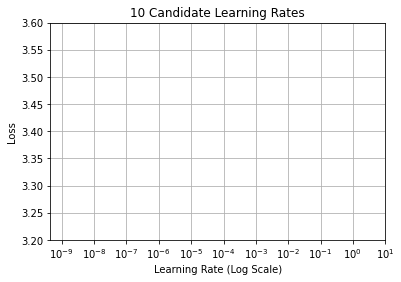

In [ ]:
# plot the loss for the candidate learning rates
# @ylimit: parameter to set the min and max displayed on the y-axis (loss axis)
lrf.plot_loss(ylimit=[3.2, 3.6])

#### Run Model

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=10, 
                                            verbose=0, mode='auto', baseline=None, restore_best_weights=True)
train_results = model.fit(
    #train_ds,
    train_generator,
    validation_data = val_generator,
    #tf_train_dataset,
    #validation_data= val_ds,
    #validation_data = tf_val_dataset,
    epochs = 50,
    callbacks=[early_stop])
#)
# callbacks=[early_stop])

Epoch 1/50
495/495 [==============================] - 276s 553ms/step - loss: 6.7834 - accuracy: 0.1502 - top-5-accuracy: 0.4383 - val_loss: 2.9676 - val_accuracy: 0.1049 - val_top-5-accuracy: 0.4451
Epoch 2/50
495/495 [==============================] - 273s 552ms/step - loss: 2.7526 - accuracy: 0.1853 - top-5-accuracy: 0.5105 - val_loss: 2.9806 - val_accuracy: 0.1289 - val_top-5-accuracy: 0.4380
Epoch 3/50
495/495 [==============================] - 273s 552ms/step - loss: 2.6570 - accuracy: 0.2060 - top-5-accuracy: 0.5495 - val_loss: 2.8177 - val_accuracy: 0.1912 - val_top-5-accuracy: 0.5079
Epoch 4/50
495/495 [==============================] - 273s 552ms/step - loss: 2.5817 - accuracy: 0.2253 - top-5-accuracy: 0.5759 - val_loss: 2.7308 - val_accuracy: 0.1901 - val_top-5-accuracy: 0.5172
Epoch 5/50
495/495 [==============================] - 273s 551ms/step - loss: 2.5287 - accuracy: 0.2404 - top-5-accuracy: 0.5939 - val_loss: 2.7023 - val_accuracy: 0.1791 - val_top-5-accuracy: 0.5352


In [ ]:
map_labels = dict()
i = 0
for l in np.unique(y_test):
  map_labels[l] = i
  i += 1
print(map_labels)

y_test_normalized = np.zeros(np.shape(y_test), dtype = 'int64')

for i in range(len(y_test)):
  y_test_normalized[i] = map_labels[y_test[i]]

from sklearn.utils import shuffle
obs_id_test_new, y_test_normalized = shuffle(obs_id_test, y_test_normalized)
print(y_test_normalized)
test_generator = Environmental_Patches_Generator(obs_id_test_new, y_test_normalized, BATCHSIZE)
result = model.evaluate(test_generator)

{5: 0, 68: 1, 125: 2, 129: 3, 223: 4, 553: 5, 570: 6, 605: 7, 679: 8, 692: 9, 739: 10, 979: 11, 1075: 12, 1155: 13, 1916: 14, 2196: 15, 2524: 16, 2821: 17, 2950: 18, 2992: 19, 3253: 20, 4940: 21, 4991: 22, 4999: 23, 5025: 24, 5086: 25, 5168: 26, 5192: 27, 5207: 28, 5228: 29}
[13 15 20 ...  8  2  6]
55/55 [==============================] - 51s 934ms/step - loss: 2.4844 - accuracy: 0.2578 - top-5-accuracy: 0.6066


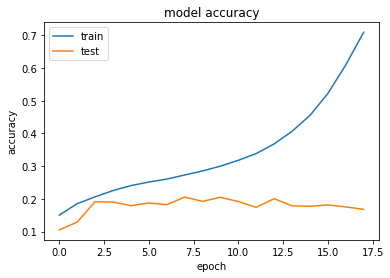

In [ ]:
# summarize history for accuracy
#FROM https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
plt.plot(train_results.history['accuracy'])
plt.plot(train_results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

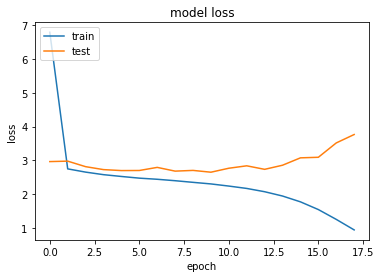

In [ ]:
# summarize history for loss
plt.plot(train_results.history['loss'])
plt.plot(train_results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=10, 
                                            verbose=0, mode='auto', baseline=None, restore_best_weights=True)
train_results = model1.fit(
    #train_ds,
    train_generator,
    validation_data = val_generator,
    #tf_train_dataset,
    #validation_data= val_ds,
    #validation_data = tf_val_dataset,
    epochs = 50,
    callbacks=[early_stop])
#)
# callbacks=[early_stop])

Epoch 1/50
495/495 [==============================] - 278s 555ms/step - loss: 4.5573 - accuracy: 0.1416 - top-5-accuracy: 0.4091 - val_loss: 6.0775 - val_accuracy: 0.1076 - val_top-5-accuracy: 0.3900
Epoch 2/50
495/495 [==============================] - 273s 550ms/step - loss: 2.8451 - accuracy: 0.1835 - top-5-accuracy: 0.4956 - val_loss: 2.8711 - val_accuracy: 0.1502 - val_top-5-accuracy: 0.4872
Epoch 3/50
495/495 [==============================] - 273s 550ms/step - loss: 2.6987 - accuracy: 0.2061 - top-5-accuracy: 0.5364 - val_loss: 2.8522 - val_accuracy: 0.1595 - val_top-5-accuracy: 0.4904
Epoch 4/50
495/495 [==============================] - 273s 550ms/step - loss: 2.5886 - accuracy: 0.2280 - top-5-accuracy: 0.5718 - val_loss: 2.9544 - val_accuracy: 0.1251 - val_top-5-accuracy: 0.4697
Epoch 5/50
495/495 [==============================] - 273s 552ms/step - loss: 2.5221 - accuracy: 0.2426 - top-5-accuracy: 0.5947 - val_loss: 2.6939 - val_accuracy: 0.2032 - val_top-5-accuracy: 0.5363


In [ ]:
test_generator = Environmental_Patches_Generator(obs_id_test_new, y_test_normalized, BATCHSIZE)
result = model1.evaluate(test_generator)

55/55 [==============================] - 30s 538ms/step - loss: 2.4418 - accuracy: 0.2684 - top-5-accuracy: 0.6223


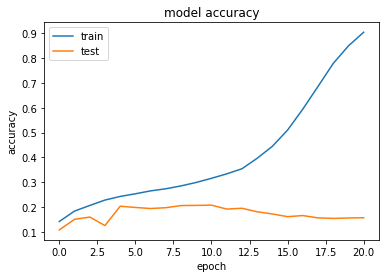

In [ ]:
# summarize history for accuracy
#FROM https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
plt.plot(train_results.history['accuracy'])
plt.plot(train_results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

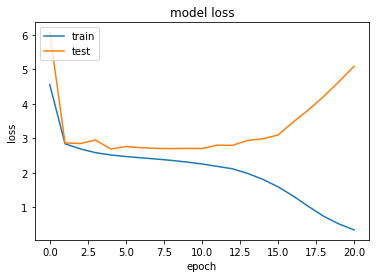

In [ ]:
# summarize history for loss
plt.plot(train_results.history['loss'])
plt.plot(train_results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=10, 
                                            verbose=0, mode='auto', baseline=None, restore_best_weights=True)
train_results = model2.fit(
    #train_ds,
    train_generator,
    validation_data = val_generator,
    #tf_train_dataset,
    #validation_data= val_ds,
    #validation_data = tf_val_dataset,
    epochs = 50,
    callbacks=[early_stop])
#)
# callbacks=[early_stop])

Epoch 1/50
495/495 [==============================] - 277s 554ms/step - loss: 4.4419 - accuracy: 0.1430 - top-5-accuracy: 0.4066 - val_loss: 50.6928 - val_accuracy: 0.1147 - val_top-5-accuracy: 0.3823
Epoch 2/50
495/495 [==============================] - 273s 551ms/step - loss: 2.9131 - accuracy: 0.1776 - top-5-accuracy: 0.4901 - val_loss: 2.9308 - val_accuracy: 0.1398 - val_top-5-accuracy: 0.4522
Epoch 3/50
495/495 [==============================] - 273s 551ms/step - loss: 2.7444 - accuracy: 0.1976 - top-5-accuracy: 0.5278 - val_loss: 2.8434 - val_accuracy: 0.1518 - val_top-5-accuracy: 0.5052
Epoch 4/50
495/495 [==============================] - 273s 550ms/step - loss: 2.6313 - accuracy: 0.2186 - top-5-accuracy: 0.5627 - val_loss: 2.7686 - val_accuracy: 0.1786 - val_top-5-accuracy: 0.5243
Epoch 5/50
495/495 [==============================] - 273s 552ms/step - loss: 2.5593 - accuracy: 0.2348 - top-5-accuracy: 0.5868 - val_loss: 2.7249 - val_accuracy: 0.1835 - val_top-5-accuracy: 0.5407

In [ ]:
test_generator = Environmental_Patches_Generator(obs_id_test_new, y_test_normalized, BATCHSIZE)
result = model2.evaluate(test_generator)

55/55 [==============================] - 30s 537ms/step - loss: 2.5010 - accuracy: 0.2429 - top-5-accuracy: 0.6028


In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=10, 
                                            verbose=0, mode='auto', baseline=None, restore_best_weights=True)
train_results = model3.fit(
    #train_ds,
    train_generator,
    validation_data = val_generator,
    #tf_train_dataset,
    #validation_data= val_ds,
    #validation_data = tf_val_dataset,
    epochs = 50,
    callbacks=[early_stop])
#)
# callbacks=[early_stop])

Epoch 1/50
495/495 [==============================] - 279s 555ms/step - loss: 4.4459 - accuracy: 0.1355 - top-5-accuracy: 0.3920 - val_loss: 3.2563 - val_accuracy: 0.1109 - val_top-5-accuracy: 0.3938
Epoch 2/50
495/495 [==============================] - 272s 549ms/step - loss: 2.8521 - accuracy: 0.1867 - top-5-accuracy: 0.5028 - val_loss: 2.9606 - val_accuracy: 0.1333 - val_top-5-accuracy: 0.4681
Epoch 3/50
495/495 [==============================] - 270s 546ms/step - loss: 2.6835 - accuracy: 0.2116 - top-5-accuracy: 0.5498 - val_loss: 2.7956 - val_accuracy: 0.1770 - val_top-5-accuracy: 0.5238
Epoch 4/50
495/495 [==============================] - 270s 545ms/step - loss: 2.6294 - accuracy: 0.2253 - top-5-accuracy: 0.5682 - val_loss: 2.9319 - val_accuracy: 0.1273 - val_top-5-accuracy: 0.4577
Epoch 5/50
495/495 [==============================] - 269s 543ms/step - loss: 2.5598 - accuracy: 0.2365 - top-5-accuracy: 0.5908 - val_loss: 2.7066 - val_accuracy: 0.1906 - val_top-5-accuracy: 0.5407


In [ ]:
test_generator = Environmental_Patches_Generator(obs_id_test_new, y_test_normalized, BATCHSIZE)
result = model3.evaluate(test_generator)

55/55 [==============================] - 30s 547ms/step - loss: 2.4220 - accuracy: 0.2814 - top-5-accuracy: 0.6298


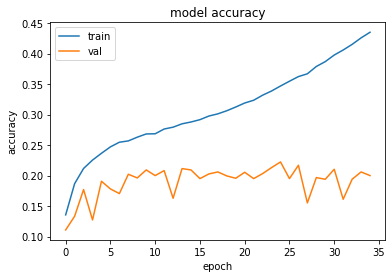

In [ ]:
# summarize history for accuracy
#FROM https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
plt.plot(train_results.history['accuracy'])
plt.plot(train_results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

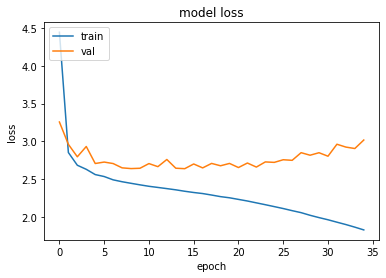

In [ ]:
# summarize history for loss
plt.plot(train_results.history['loss'])
plt.plot(train_results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#w/ the last dense layer and 255 rescaling
#before dropout
#with weight decay

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=10, 
                                            verbose=0, mode='auto', baseline=None, restore_best_weights=True)
train_results = model4.fit(
    #train_ds,
    train_generator,
    validation_data = val_generator,
    #tf_train_dataset,
    #validation_data= val_ds,
    #validation_data = tf_val_dataset,
    epochs = 50,
    callbacks=[early_stop])
#)
# callbacks=[early_stop])

Epoch 1/50
495/495 [==============================] - 278s 558ms/step - loss: 12.2649 - accuracy: 0.1409 - top-5-accuracy: 0.4054 - val_loss: 8.8770 - val_accuracy: 0.1212 - val_top-5-accuracy: 0.3943
Epoch 2/50
495/495 [==============================] - 274s 552ms/step - loss: 7.4826 - accuracy: 0.1902 - top-5-accuracy: 0.5040 - val_loss: 7.1017 - val_accuracy: 0.1387 - val_top-5-accuracy: 0.4418
Epoch 3/50
495/495 [==============================] - 273s 550ms/step - loss: 6.0728 - accuracy: 0.2078 - top-5-accuracy: 0.5320 - val_loss: 5.8259 - val_accuracy: 0.1611 - val_top-5-accuracy: 0.5057
Epoch 4/50
495/495 [==============================] - 273s 551ms/step - loss: 5.2415 - accuracy: 0.2203 - top-5-accuracy: 0.5517 - val_loss: 5.1665 - val_accuracy: 0.1709 - val_top-5-accuracy: 0.4970
Epoch 5/50
495/495 [==============================] - 273s 550ms/step - loss: 4.7125 - accuracy: 0.2295 - top-5-accuracy: 0.5644 - val_loss: 4.7452 - val_accuracy: 0.1780 - val_top-5-accuracy: 0.5030

In [ ]:
test_generator = Environmental_Patches_Generator(obs_id_test_new, y_test_normalized, BATCHSIZE)
result = model4.evaluate(test_generator)

55/55 [==============================] - 29s 528ms/step - loss: 3.5205 - accuracy: 0.2553 - top-5-accuracy: 0.5929


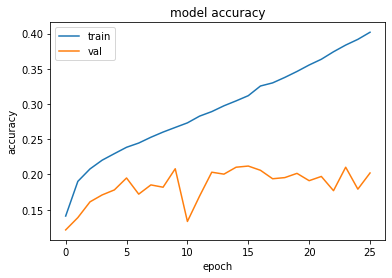

In [ ]:
# summarize history for accuracy
#FROM https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
plt.plot(train_results.history['accuracy'])
plt.plot(train_results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

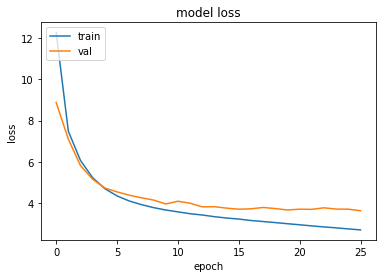

In [ ]:
# summarize history for loss
plt.plot(train_results.history['loss'])
plt.plot(train_results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#removed a dense layer and added some dropout
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=10, 
                                            verbose=0, mode='auto', baseline=None, restore_best_weights=True)
train_results = model5.fit(
    #train_ds,
    train_generator,
    validation_data = val_generator,
    #tf_train_dataset,
    #validation_data= val_ds,
    #validation_data = tf_val_dataset,
    epochs = 50,
    callbacks=[early_stop])
#)
# callbacks=[early_stop])

Epoch 1/50
495/495 [==============================] - 278s 556ms/step - loss: 21.2605 - accuracy: 0.0983 - top-5-accuracy: 0.3032 - val_loss: 9.6690 - val_accuracy: 0.1486 - val_top-5-accuracy: 0.3796
Epoch 2/50
495/495 [==============================] - 273s 550ms/step - loss: 9.0076 - accuracy: 0.1415 - top-5-accuracy: 0.3925 - val_loss: 7.0572 - val_accuracy: 0.1442 - val_top-5-accuracy: 0.4353
Epoch 3/50
495/495 [==============================] - 274s 553ms/step - loss: 6.6518 - accuracy: 0.1668 - top-5-accuracy: 0.4441 - val_loss: 5.7848 - val_accuracy: 0.1354 - val_top-5-accuracy: 0.4713
Epoch 4/50
495/495 [==============================] - 273s 551ms/step - loss: 5.4600 - accuracy: 0.1860 - top-5-accuracy: 0.4836 - val_loss: 5.1358 - val_accuracy: 0.1589 - val_top-5-accuracy: 0.4642
Epoch 5/50
495/495 [==============================] - 272s 550ms/step - loss: 4.7128 - accuracy: 0.2063 - top-5-accuracy: 0.5164 - val_loss: 4.5209 - val_accuracy: 0.1709 - val_top-5-accuracy: 0.4828

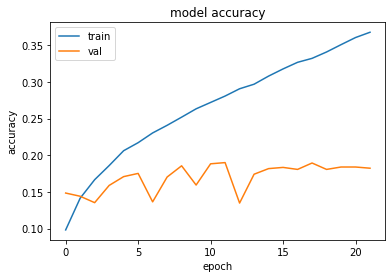

In [ ]:
# summarize history for accuracy
#FROM https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
plt.plot(train_results.history['accuracy'])
plt.plot(train_results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

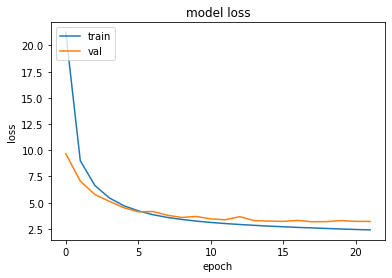

In [ ]:
# summarize history for loss
plt.plot(train_results.history['loss'])
plt.plot(train_results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

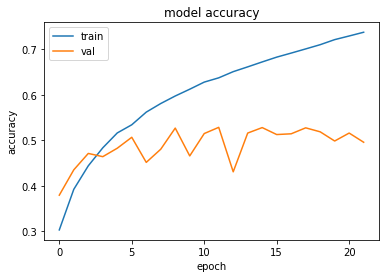

In [ ]:
# summarize history for accuracy
#FROM https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
plt.plot(train_results.history['top-5-accuracy'])
plt.plot(train_results.history['val_top-5-accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Run Model Pretrained

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.001, patience=10, 
                                            verbose=0, mode='auto', baseline=None, restore_best_weights=True)
train_results = model1.fit(
    #train_ds,
    train_generator,
    validation_data = val_generator,
    #tf_train_dataset,
    #validation_data= val_ds,
    #validation_data = tf_val_dataset,
    epochs = 100,
    callbacks=[early_stop])
#)
# callbacks=[early_stop])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


  266/24804 [..............................] - ETA: 3:38:42 - loss: 8.7786 - accuracy: 0.0031 - top-5-accuracy: 0.0150

KeyboardInterrupt: ignored

### Test Submission

In [ ]:
test_generator = Test_Patches_Generator(obs_id_test, BATCHSIZE)

tf_test_dataset = tf.data.Dataset.from_generator(
    lambda: test_generator,  # Our generator 
    output_types = (tf.float32 , tf.float32), # How we're expecting our output dtype
    #output_shapes = ([BATCHSIZE, 256 , 256, 3] , [BATCHSIZE, ]) # How we're expecting our output shape
    #output_shapes = (tf.TensorShape(features_shape), [BATCHSIZE, ]),
)

In [ ]:
import os
SUBMISSION_PATH = Path("submissions")
os.makedirs(SUBMISSION_PATH, exist_ok=True)


In [ ]:
from GLC.submission import generate_submission_file


n_test = len(df_obs_test)
s_pred = model.predict_generator(test_generator)

# Generate the submission file


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


NameError: ignored

In [ ]:
print(s_pred[11])

NameError: ignored

In [ ]:
generate_submission_file("./submissions/new", df_obs_test.index, s_pred)